# Introduction

1. Checkout the [Keras guide on using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/). Can you get this working with one of our models?
  * Hint: You'll want to incorporate it with a custom token Embedding layer.
It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.

2. Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the TensorFlow Hub BERT PubMed expert (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?
  * Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences ([as detailed in the TensorFlow Hub guide](https://tfhub.dev/google/experts/bert/pubmed/2)).
  * Does the BERT model beat the results mentioned in this paper? (https://arxiv.org/pdf/1710.06071.pdf).

3. What happens if you were to merge our `line_number` and `total_lines` features for each sequence? For example, created a `X_of_Y` feature instead? Does this effect model performance?
  * Another example: `line_number=1` and `total_lines=11` turns into `line_of_X=1_of_11`.

4. Train `model_5` on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:
  * `tf.keras.callbacks.ModelCheckpoint` to save the model's best weights only.
  * `tf.keras.callbacks.EarlyStopping` to stop the model from training once the validation loss has stopped improving for ~3 epochs.

5. Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:

PREDICTED_LABEL: SEQUENCE

PREDICTED_LABEL: SEQUENCE

PREDICTED_LABEL: SEQUENCE

PREDICTED_LABEL: SEQUENCE



# Downloading the dataset and preprocessing

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# Importing the helper_functions file
import os

if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/DavAll22/Extra-Code/main/helper_functions_TF.py
else:
  print("[INFO] 'helper_functions_TF.py' already exists, skipping download.")

--2023-06-13 12:23:16--  https://raw.githubusercontent.com/DavAll22/Extra-Code/main/helper_functions_TF.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13751 (13K) [text/plain]
Saving to: ‘helper_functions_TF.py’

helper_functions_TF 100%[===================>]  13.43K  --.-KB/s    in 0s      

2023-06-13 12:23:17 (72.6 MB/s) - ‘helper_functions_TF.py’ saved [13751/13751]



In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.81 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
# Creating a preprocessing function that returns a dictionary
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 342 ms, sys: 82.9 ms, total: 425 ms
Wall time: 427 ms


(180040, 30212, 30135)

In [10]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
# Loading our data into a dataframe
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [13]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## One-hot encoding and label-encoding labels

In [14]:
# One hot encoding the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [15]:
# Extract labels and encoder them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [16]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# 1. GloVe Embedding model

In [17]:
# Loading the pre-trained embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-06-13 12:23:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-13 12:23:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-13 12:23:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

GloVe archive contains various size text-encoded vectors (50-D, 100-D, 200-D, 300-D). We're using the 100-D.

In [18]:
# Making a dictionary mapping words (strings) to their NumPy vector representation

# Getting the path of the glove embedding (using 100D)
import numpy as np
glove_path = 'glove.6B.100d.txt'

embedding_index = {}

# Making dict of vector representtion of the words (s --> [8, 48......])
with open(glove_path) as f:
  for line in f:

    # Getting the words and coef in a variable
    word , coefs = line.split(maxsplit = 1)
    coefs = np.fromstring(coefs , 'f' , sep = ' ')

    # Adding the coefs to our embedding dict
    embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


In [19]:
# Creating a corresponding embedding matrix to fit the `embedding_index` to our Embedding layer

# Getting the sentences and characters
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

In [20]:
# Creating a a text vectorizaiton layer (68k vocab size from the paper itself)
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens= 68000 ,
                                    output_sequence_length = 56)

# Adapt our text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [21]:
# Getting the vocabulary of the vectorizer
text_vocab = text_vectorizer.get_vocabulary()
len(text_vocab)

64841

In [22]:
# Getting the dict mapping word --> index
word_index_text = dict(zip(text_vocab , range(len(text_vocab))))

In [23]:
# Creating a function that will give us a embedding matrix
def get_glove_embedding_matrix(num_tokens , embedding_dim , word_index):

  # Defining the hits and misses here
  hits , misses = 0 , 0

  # Prepare the embedding matrix
  embedding_matrix = np.zeros((num_tokens , embedding_dim )) # blank matrix initialisation
  for word , i in word_index.items():
    embedding_vector = embedding_index.get(word) # get the embedded word from the GloVe embedding
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # Add the embedding to the matrix
      hits += 1
    else:
      misses += 1

  return embedding_matrix , hits , misses

In [24]:
# Using the above function to get the embedding matrix

num_tokens_text = len(text_vocab) + 2 # Vocab list + space + unknown (OOV)
embedding_dim = 100

sentence_embedding_matrix , hits_ , misses_ = get_glove_embedding_matrix(num_tokens_text , embedding_dim, word_index_text)


print(f'Hits: {hits_} and Misses: {misses_} for the sentence embedding matrix')

Hits: 29730 and Misses: 35111 for the sentence embedding matrix


In [25]:
# Adding the embedding matrix to our Embedding layer (Sentence and characters)
from tensorflow.keras.layers import Embedding

sen_embedding_layer = Embedding(num_tokens_text ,
                            embedding_dim ,
                            embeddings_initializer = tf.keras.initializers.Constant(sentence_embedding_matrix) , # initialising the embedding with teh GloVe embeddings learned
                            trainable = False )

## GloVe Modelling

In [26]:
# Creating the datasets for our both sentences and chars

train_sen_vectors = text_vectorizer(np.array([[sen] for sen in train_sentences])).numpy() # vectorizing the sentences
val_sen_vectors = text_vectorizer(np.array([[sen] for sen in val_sentences])).numpy()

# Training and validation dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_sen_vectors , train_labels_encoded)) # Creating datset using tf.data API
val_ds = tf.data.Dataset.from_tensor_slices((val_sen_vectors , val_labels_encoded))


# Applying the batch size and prefetching (performance optimization )
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)


train_ds,  val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 56), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 56), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [27]:
train_sen_vectors[0].shape

(56,)

In [28]:
# Sample
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer(input)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax')(x)
glove_model = tf.keras.Model(input, output, name='glove_model')

glove_model.summary()

Model: "glove_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         6484300   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                   

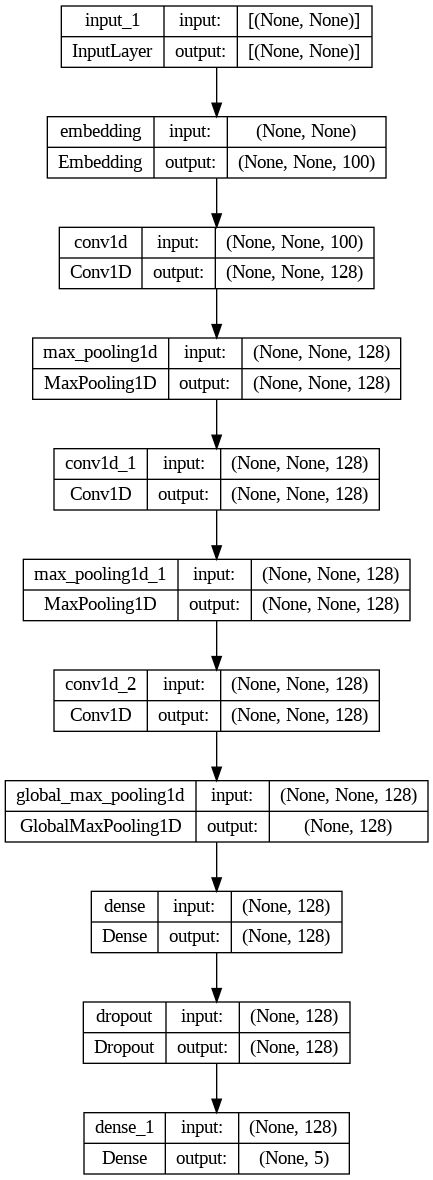

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(glove_model, show_shapes=True)

In [30]:
# Compiling and fitting the model
glove_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = ['accuracy'])

glove_model_history = glove_model.fit(train_ds,
                                      epochs=3,
                                      validation_data = val_ds)

Epoch 1/3
5627/5627 [==============================] - 44s 6ms/step - loss: 0.6513 - accuracy: 0.7587 - val_loss: 0.5288 - val_accuracy: 0.8045
Epoch 2/3
5627/5627 [==============================] - 32s 6ms/step - loss: 0.5308 - accuracy: 0.8077 - val_loss: 0.5049 - val_accuracy: 0.8155
Epoch 3/3
5627/5627 [==============================] - 32s 6ms/step - loss: 0.4851 - accuracy: 0.8244 - val_loss: 0.5172 - val_accuracy: 0.8136


In [31]:
# Evaluate model_3 on whole validation char dataset
glove_model.evaluate(val_ds)

945/945 [==============================] - 3s 3ms/step - loss: 0.5172 - accuracy: 0.8136


[0.5172039866447449, 0.8136171102523804]

In [32]:
# Make predictions on glove model using validation set
glove_model_probs = glove_model.predict(val_ds)

glove_model_preds = glove_model_probs.argmax(axis=1)
glove_model_preds[:10]

945/945 [==============================] - 2s 2ms/step


array([1, 0, 3, 2, 2, 4, 4, 4, 4, 2])

In [33]:
# Evaluate model test predictions
from helper_functions_TF import calculate_results
glove_model_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=glove_model_preds)

glove_model_results

{'accuracy': 81.36171057857806,
 'precision': 0.8141886164786747,
 'recall': 0.8136171057857805,
 'f1': 0.8111883909513318}

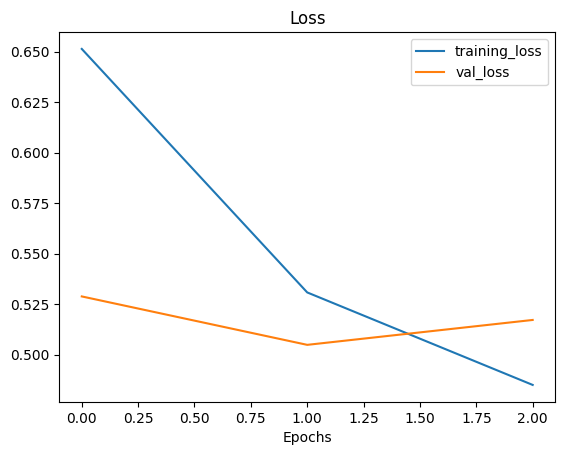

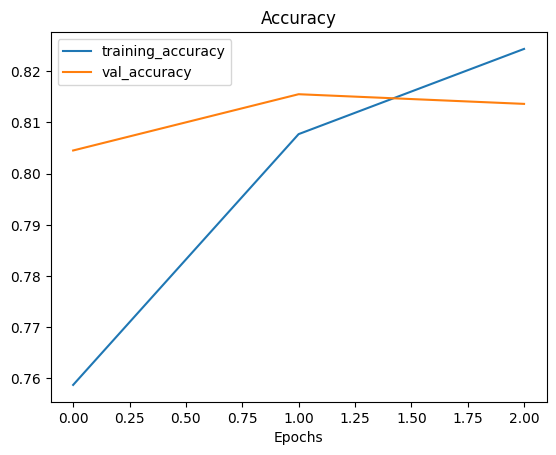

In [34]:
# Getting loss curves
from helper_functions_TF import plot_loss_curves
plot_loss_curves(glove_model_history)

Model is overfitting the data (validation loss constant while training loss decreases)

# 2. BERT PubMed pre-trained embeddings

In [35]:
# Download by uncommenting the below command
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 88.8 MB/s eta 0:00:00


In [36]:
# Loading in the both encoder and the preprocessing models
import tensorflow_text as text
import tensorflow_hub as hub


preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3' , # required vectorizer for the BERT model embedding encoder.
                                     trainable = False , name = 'pubmed_bert_preprocessor')

bert_layer = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2' ,
                            trainable = False ,
                            name = 'bert_model_layer')

In [37]:
# Creating a model out of it
input = layers.Input(shape = [] , dtype = tf.string , name = 'input_sentences')
bert_inputs = preprocessing_layer(input) # vectorizer/preprocessor
bert_embedding = bert_layer(bert_inputs) # embedding layer
print(f'bert embedding shape: {bert_embedding}')
x = layers.Dense(128 , activation = 'relu')(bert_embedding['pooled_output'])
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax')(x)

# Packing into a model
pubmed_bert_model = tf.keras.Model(input , output)
pubmed_bert_model.summary()

bert embedding shape: {'sequence_output': <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, 'default': <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert_model_layer')>, 'encoder_outputs': [<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(N

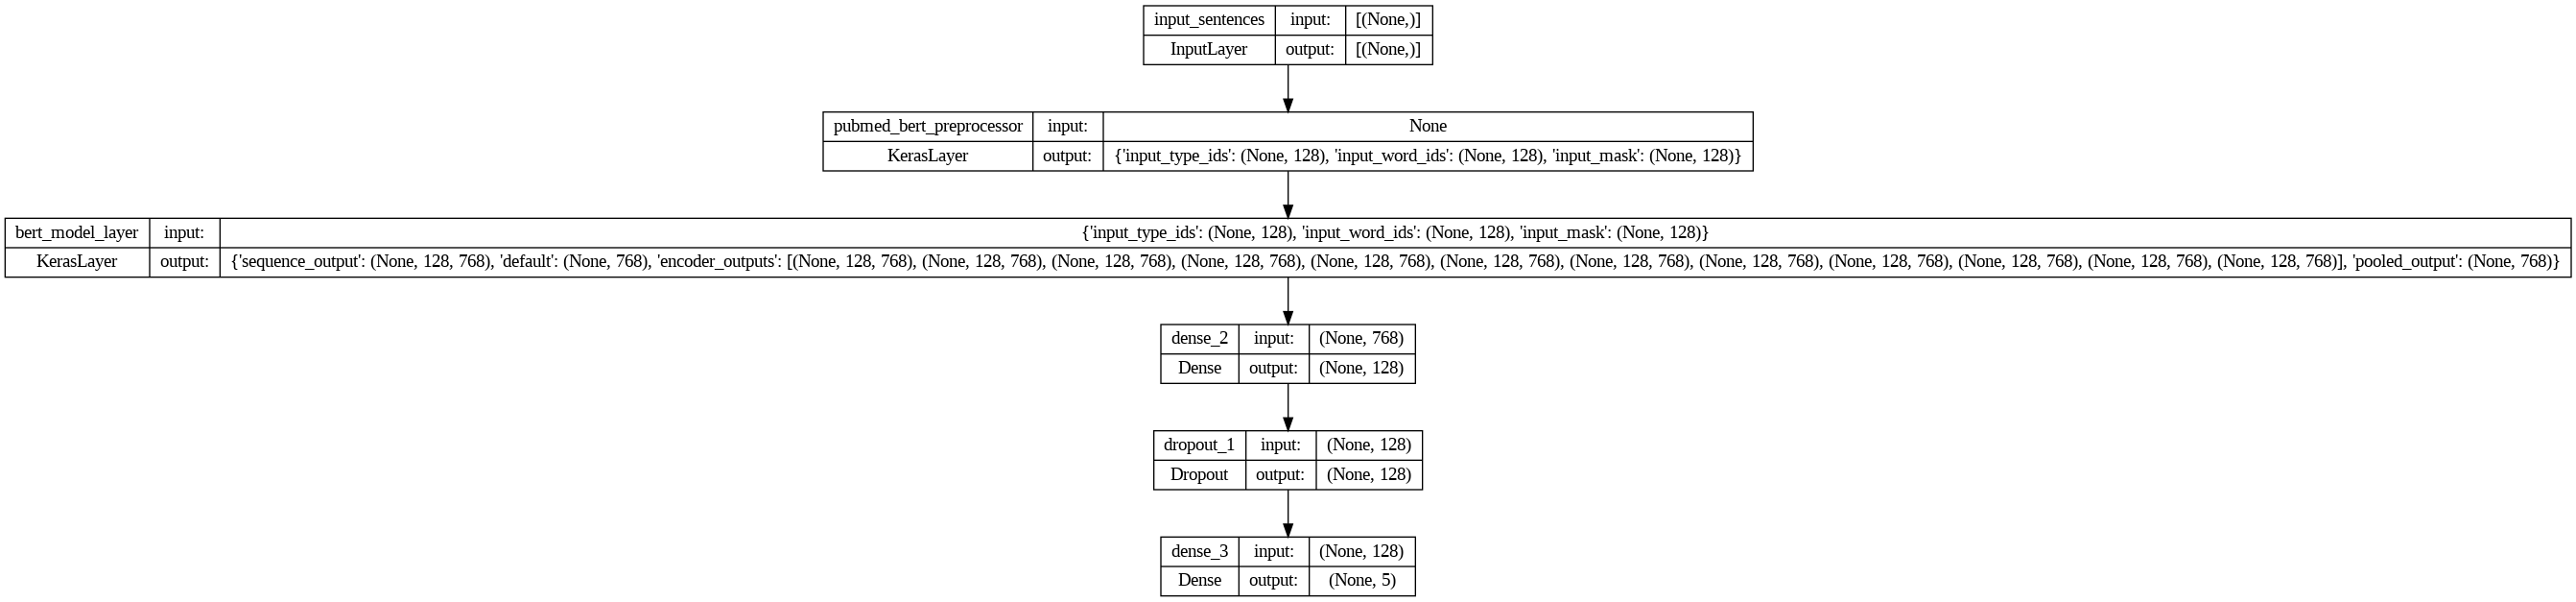

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(pubmed_bert_model, show_shapes=True)

In [39]:
# Making datasets for the pubmed model

train_sen_ds = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
train_sen_ds = train_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)

val_sen_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))
val_sen_ds = val_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [40]:
# Compiling the Pubmed model and fitting it on 10% of the data for speed

pubmed_bert_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() ,
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics =['accuracy'])

pubmed_bert_model_history = pubmed_bert_model.fit(train_sen_ds ,
                                                  steps_per_epoch = int(0.1 * len(train_sen_ds)),
                                                  epochs = 3 ,
                                                  validation_data = val_sen_ds ,
                                                  validation_steps = int(0.1 * len(val_sen_ds)))

Epoch 1/3
562/562 [==============================] - 236s 396ms/step - loss: 0.6436 - accuracy: 0.7773 - val_loss: 0.4445 - val_accuracy: 0.8444
Epoch 2/3
562/562 [==============================] - 223s 397ms/step - loss: 0.5170 - accuracy: 0.8220 - val_loss: 0.4431 - val_accuracy: 0.8374
Epoch 3/3
562/562 [==============================] - 230s 410ms/step - loss: 0.5004 - accuracy: 0.8281 - val_loss: 0.4295 - val_accuracy: 0.8521


In [41]:
# Evaluate model on whole dataset
pubmed_bert_model.evaluate(val_sen_ds)

945/945 [==============================] - 319s 337ms/step - loss: 0.4272 - accuracy: 0.8492


[0.4271816611289978, 0.8492320775985718]

In [42]:
# Make predictions on bert model with validation set
pubmed_bert_model_probs = pubmed_bert_model.predict(val_sen_ds)

pubmed_bert_model_preds = pubmed_bert_model_probs.argmax(axis=1)
pubmed_bert_model_preds[:10]

945/945 [==============================] - 313s 330ms/step


array([1, 0, 3, 2, 2, 4, 4, 4, 4, 1])

In [43]:
# Evaluate model test predictions
pubmed_bert_model_results = calculate_results(y_true=val_labels_encoded,
                                              y_pred=pubmed_bert_model_preds)

pubmed_bert_model_results

{'accuracy': 84.92320932079969,
 'precision': 0.8513960980836681,
 'recall': 0.8492320932079969,
 'f1': 0.8493100236216394}

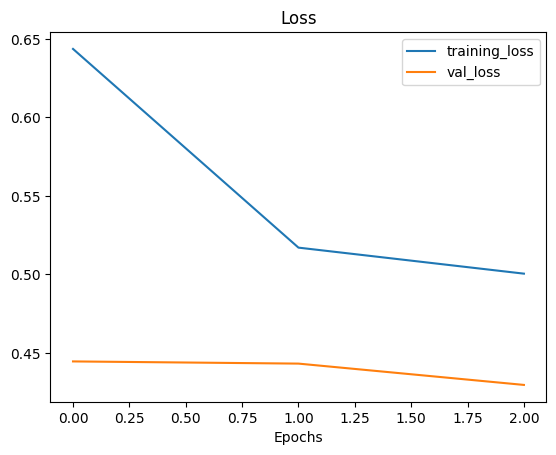

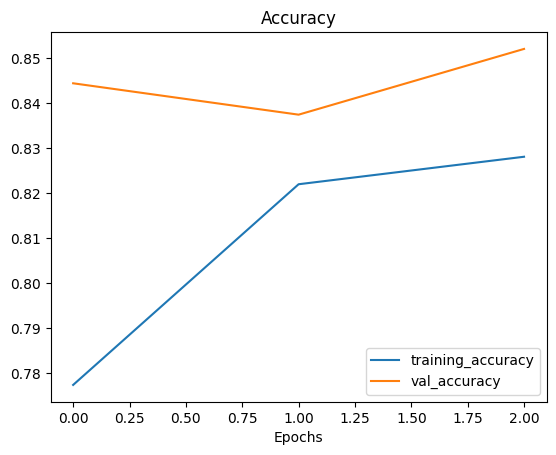

In [44]:
# Loss curve
plot_loss_curves(pubmed_bert_model_history)

# 3. Tribrid model using the line_number and total_lines features in format X_of_Y from model_5 as well as the BERT model.

In [45]:
# Combining the total lines and line number into a new feature!
train_df['line_number_total'] = train_df['line_number'].astype(str) + '_of_' + train_df['total_lines'].astype(str)
val_df['line_number_total'] = val_df['line_number'].astype(str) + '_of_' + val_df['total_lines'].astype(str)

train_df.head(10)

,target,text,line_number,total_lines,line_number_total
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,0_of_11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,1_of_11
2,METHODS,outcome measures included pain reduction and i...,2,11,2_of_11
3,METHODS,pain was assessed using the visual analog pain...,3,11,3_of_11
4,METHODS,secondary outcome measures included the wester...,4,11,4_of_11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11,5_of_11
6,RESULTS,there was a clinically relevant reduction in t...,6,11,6_of_11
7,RESULTS,the mean difference between treatment arms ( @...,7,11,7_of_11
8,RESULTS,"further , there was a clinically relevant redu...",8,11,8_of_11
9,RESULTS,these differences remained significant at @ we...,9,11,9_of_11


In [46]:
# Perform one hot encoding on the train and transform the validation dataframe
from sklearn.preprocessing import OneHotEncoder

# Creating an instance
one_hot_encoder = OneHotEncoder()

# Fitting on the training dataframe
one_hot_encoder.fit(np.expand_dims(train_df['line_number_total'] , axis = 1))

# Transforming both train and val df
train_line_number_total_encoded = one_hot_encoder.transform(np.expand_dims(train_df['line_number_total'] , axis =1))
val_line_number_total_encoded  = one_hot_encoder.transform(np.expand_dims(val_df['line_number_total'] , axis= 1))

# Checking the shapes
train_line_number_total_encoded.shape , val_line_number_total_encoded.shape

((180040, 460), (30212, 460))

In [47]:
# Converting the sparse object to array
train_line_number_total_encoded = train_line_number_total_encoded.toarray()
val_line_number_total_encoded = val_line_number_total_encoded.toarray()

# Converting the datatype to int
train_line_number_total_encoded = tf.cast(train_line_number_total_encoded , dtype= tf.int32)
val_line_number_total_encoded = tf.cast(val_line_number_total_encoded , dtype= tf.int32)

Tribrid model using pubmed Bert as the embedding, and model the line_number_total feature in combination with line_number and total_lines.

This differs from model_5 by combining the feature engineering parameters of line_number and total_lines into one variable which has been one-hot encoded, so there weill be 3 inputs to the model, not 4.

In [48]:
# Making the performant datasets for our tribid model
train_data = tf.data.Dataset.from_tensor_slices((train_sentences ,
                                                 train_chars ,
                                                 train_line_number_total_encoded))

train_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded)

val_data = tf.data.Dataset.from_tensor_slices((val_sentences ,
                                               val_chars ,
                                               val_line_number_total_encoded))

val_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded)

# Zipping the data and labels
train_dataset = tf.data.Dataset.zip((train_data , train_labels))
val_dataset = tf.data.Dataset.zip((val_data , val_labels))

# Applying batch and prefetching
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

train_dataset , val_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [49]:
# Buidling the tribid model using the functional api

input_token = layers.Input(shape = [] , dtype =tf.string)
bert_inputs_token = preprocessing_layer(input_token)
bert_embedding_char = bert_layer(bert_inputs_token)
output_token = layers.Dense(64 , activation = 'relu')(bert_embedding_char['pooled_output'])
token_model = tf.keras.Model(input_token , output_token)

input_char = layers.Input(shape = [] , dtype =tf.string)
bert_inputs_char = preprocessing_layer(input_char)
bert_embedding_char = bert_layer(bert_inputs_char)
output_char = layers.Dense(64 , activation = 'relu')(bert_embedding_char['pooled_output'])
char_model = tf.keras.Model(input_char , output_char)

line_number_total_input = layers.Input(shape = (460,), dtype = tf.int32) # 460 is the shape of the vector for the line_number_total (how many columns are used for on-hot encoding)
dense = layers.Dense(32 , activation = 'relu')(line_number_total_input)
total_line_number_model = tf.keras.Model(line_number_total_input , dense)

# Concatenating the tokens amd chars output (Hybrid!!!)
combined_embeddings = layers.Concatenate(name = 'token_char_hybrid_embedding')([token_model.output ,
                                                                                char_model.output])

# Combining the line_number_total to our hybrid model (Time for Tribid!!)
z = layers.Concatenate(name = 'tribid_embeddings')([total_line_number_model.output ,
                                                    combined_embeddings])

# Adding a dense + dropout and creating our output layer
dropout = layers.Dropout(0.5)(z)
x = layers.Dense(128 , activation='relu')(dropout)
output_layer = layers.Dense(5 , activation='softmax')(x)

# Packing into a model
tribid_model = tf.keras.Model(inputs = [token_model.input ,
                                        char_model.input ,
                                        total_line_number_model.input] ,
                              outputs = output_layer)

tribid_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor (Kera  {'input_type_ids':   0          ['input_2[0][0]',                
 sLayer)                        (None, 128),                      'input_3[0][0]']                
                                 'input_word_ids':                                                
                                (None, 128),                                                

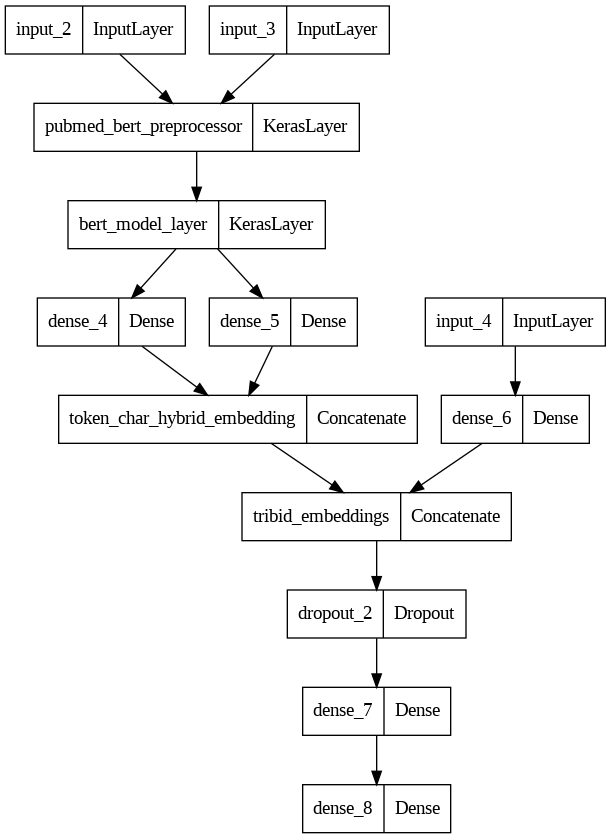

In [50]:
# Plotting the model structure
from tensorflow.keras.utils import plot_model
plot_model(tribid_model)

In [51]:
# Compiling and fitting the model (Fun Part!)
tribid_model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer= tf.keras.optimizers.Adam() ,
                     metrics = ['accuracy'])

# Fitting the model for fewer epochs  (training only on 10% of the data)
# To speed up the experimentation

tribrid_model_history = tribid_model.fit(train_dataset ,
                                          steps_per_epoch = int(0.1 * len(train_dataset)),
                                          epochs = 3 ,
                                          validation_steps = int(0.1 * len(val_dataset)),
                                          validation_data = val_dataset)

Epoch 1/3
281/281 [==============================] - 483s 2s/step - loss: 0.7153 - accuracy: 0.7435 - val_loss: 0.4263 - val_accuracy: 0.8421
Epoch 2/3
281/281 [==============================] - 478s 2s/step - loss: 0.4728 - accuracy: 0.8357 - val_loss: 0.3538 - val_accuracy: 0.8674
Epoch 3/3
281/281 [==============================] - 461s 2s/step - loss: 0.4128 - accuracy: 0.8539 - val_loss: 0.3218 - val_accuracy: 0.8830


In [54]:
# Evaluating on the whole val data
tribid_model.evaluate(val_dataset)

473/473 [==============================] - 662s 1s/step - loss: 0.3124 - accuracy: 0.8807


[0.3123967945575714, 0.8807427287101746]

In [56]:
# Make predictions on tribrid model with validation set
tribrid_model_probs = tribid_model.predict(val_dataset)

tribrid_model_preds = tribrid_model_probs.argmax(axis=1)
tribrid_model_preds[:10]

473/473 [==============================] - 660s 1s/step


array([3, 0, 3, 2, 2, 4, 4, 4, 4, 1])

In [57]:
# Evaluate model test predictions
tribrid_model_results = calculate_results(y_true=val_labels_encoded,
                                          y_pred=tribrid_model_preds)

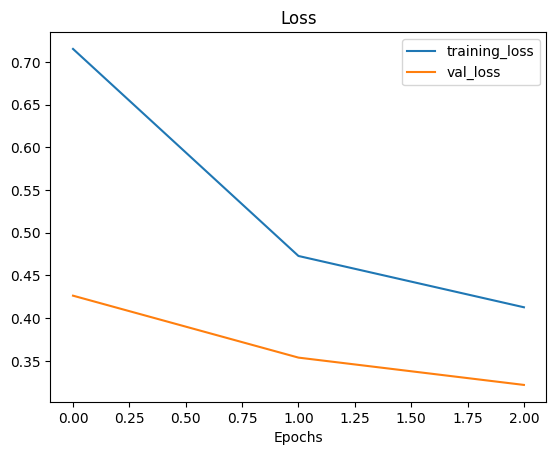

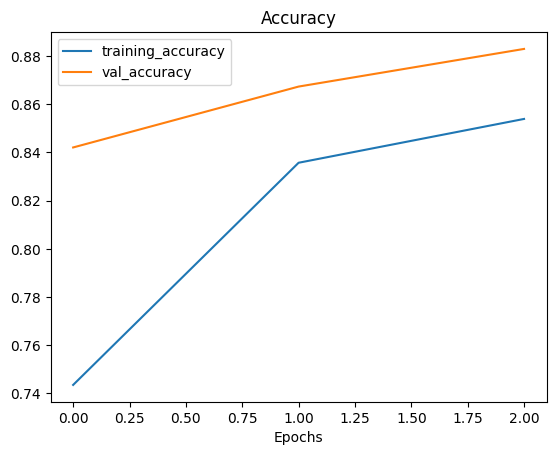

In [58]:
# Loss curve
plot_loss_curves(tribrid_model_history)

# 4. Train model_5 on all of the data in the training dataset for as many epochs until it stops improving.

In [59]:
# Require the other method of feture engineering the line numbers and total lines:

# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_line_numbers_one_hot.shape

(TensorShape([180040, 20]), TensorShape([180040, 15]))

In [60]:
# Re-building the Model 5

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_embeddings)


# 2. Char inputs
char_inputs = layers.Input(shape= [], dtype="string", name="char_inputs")
char_embeddings = tf_hub_embedding_layer(char_inputs)
exp_layer = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(char_embeddings)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(exp_layer)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)



# Summary of the model
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_inputs (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]',           
 rasLayer)                                                        'char_inputs[0][0]']            
                                                                                                  
 lambda (Lambda)                (None, 1, 512)       0           ['universal_sentence_encode

In [61]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

Creating callbacks to save the model's best weights only and to stop the model from training once validation loss has stopped improving for 3 epochs

In [62]:
# Creating the callbacks
check_filepath = 'best_weights/checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= check_filepath ,
                                                               save_weights_only = True ,
                                                               save_best_only = True  ,
                                                               save_freq = 'epoch' ,
                                                               monitor = 'val_loss')

early_stopping  = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' ,
                                                   patience = 3, min_delta = 0.5 , verbose = 1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [63]:
# Compiling the model and fitting it on the 100% of the data for 50 epochs

model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_5_history = model_5.fit(train_pos_char_token_dataset ,
                              epochs = 50 ,
                              validation_data = val_pos_char_token_dataset  ,
                              callbacks = [early_stopping , model_checkpoint_callback ,
                                          reduce_lr])

Epoch 1/50
5627/5627 [==============================] - 243s 41ms/step - loss: 0.9688 - accuracy: 0.8155 - val_loss: 0.9234 - val_accuracy: 0.8435 - lr: 0.0010
Epoch 2/50
5627/5627 [==============================] - 222s 39ms/step - loss: 0.9305 - accuracy: 0.8444 - val_loss: 0.9145 - val_accuracy: 0.8514 - lr: 0.0010
Epoch 3/50
5627/5627 [==============================] - 231s 41ms/step - loss: 0.9222 - accuracy: 0.8519 - val_loss: 0.9101 - val_accuracy: 0.8539 - lr: 0.0010
Epoch 4/50
5627/5627 [==============================] - 256s 45ms/step - loss: 0.9169 - accuracy: 0.8551 - val_loss: 0.9062 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 4: early stopping


In [64]:
# Evaluating on the val dataset
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 29s 30ms/step - loss: 0.9062 - accuracy: 0.8567


[0.9062188863754272, 0.8566794395446777]

In [65]:
# Making predictions on model_5
model_5_probs = model_5.predict(val_pos_char_token_dataset)

model_5_preds = model_5_probs.argmax(axis=1)
model_5_preds[:10]

945/945 [==============================] - 29s 29ms/step


array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

In [66]:
# Evaluate model test predictions
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.66794651132,
 'precision': 0.8573769132742736,
 'recall': 0.8566794651132,
 'f1': 0.8533509611795344}

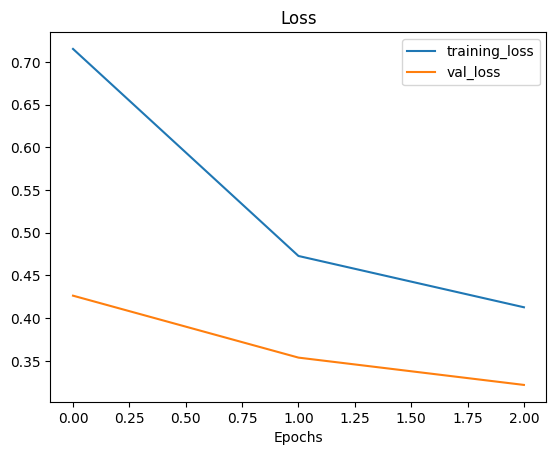

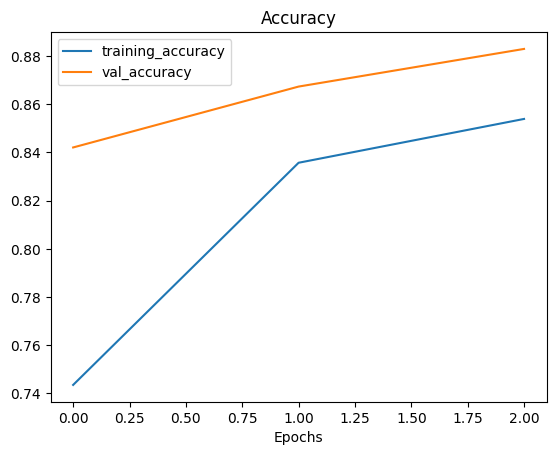

In [67]:
# Loss curve
plot_loss_curves(tribrid_model_history)

# Plot and compare the models

In [68]:
# Combine model results into a Dataframe
all_model_results = pd.DataFrame({'GloVe Embedding': glove_model_results,
                                  'PubMed BERT': pubmed_bert_model_results,
                                  'Tribrid model V2 + BERT': tribrid_model_results,
                                  'Model_5 full training': model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
GloVe Embedding,81.361711,0.814189,0.813617,0.811188
PubMed BERT,84.923209,0.851396,0.849232,0.849310
Tribrid model V2 + BERT,88.074275,0.881714,0.880743,0.880436
Model_5 full training,85.667947,0.857377,0.856679,0.853351


In [69]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

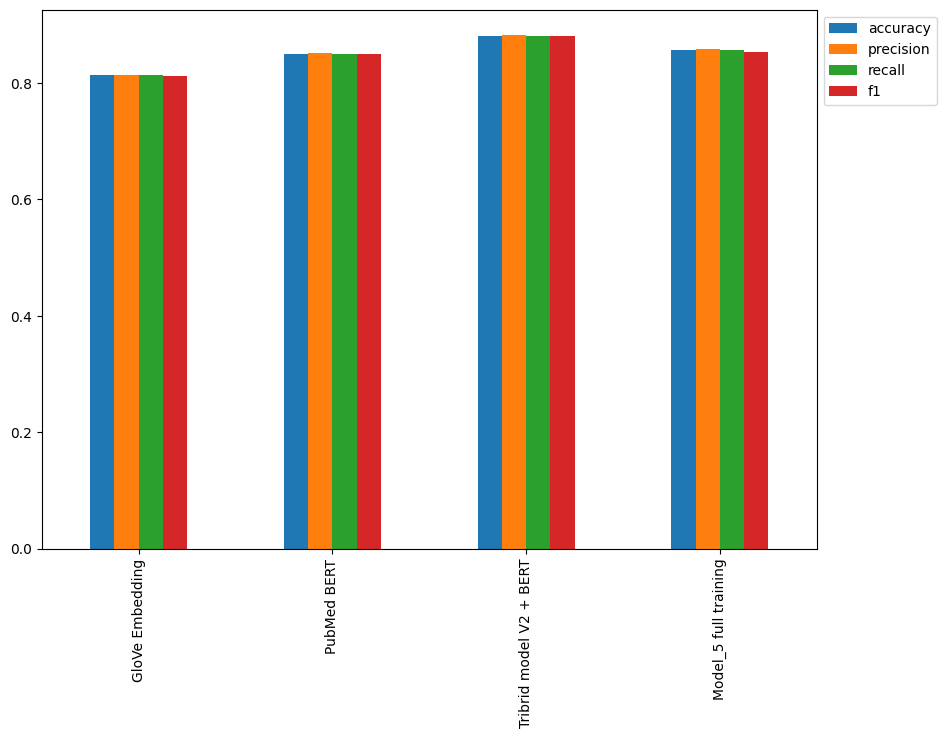

In [70]:
# Plot and compare all the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

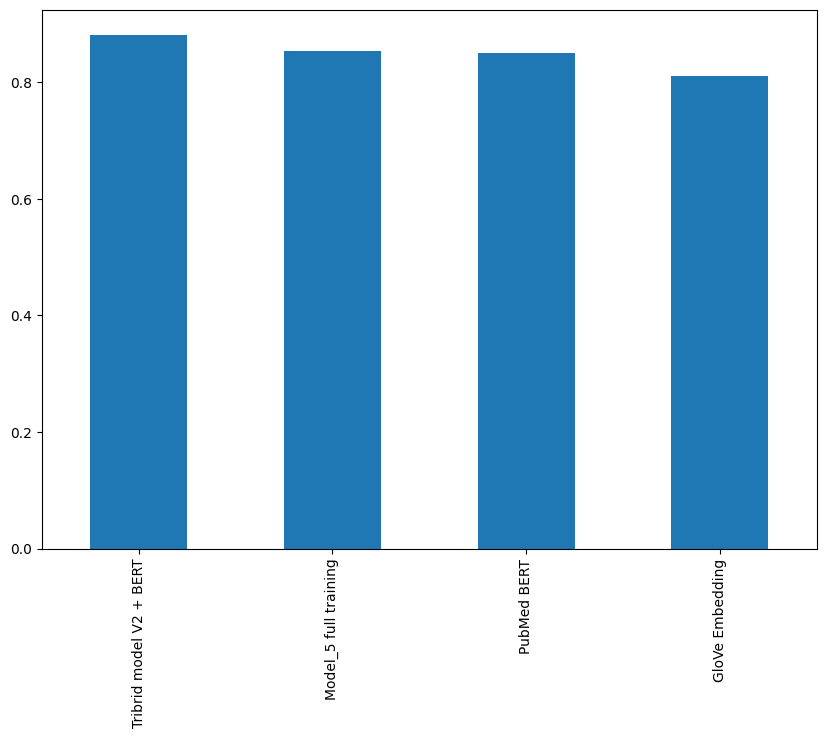

In [71]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Evaluating best model on test dataset

Evaluations on the Tribrid BERT model

# 5. Making predictions with entered abstracts

PREDICTED_LABEL: SEQUENCE

PREDICTED_LABEL: SEQUENCE

PREDICTED_LABEL: SEQUENCE

In [72]:
example_abstracts = [{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum disorders',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/'},
 {'abstract': "Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of maternal vitamin D levels with PPD outcomes showed inconsistent associations. Diet: Two Australian RCT's with dietary advice interventions in pregnancy had a positive and null result on PPD. With the exception of fish oil, few RCT's with nutritional interventions during pregnancy assess PPD. Further research is needed to determine whether nutritional intervention strategies during pregnancy can protect against symptoms of PPD. Given the prevalence of PPD and ease of administering PPD measures, we recommend future prenatal nutritional RCT's include PPD as an outcome.",
  'details': 'Formatting removed (can be used to compare model to actual example)',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/28012571/'},
 {'abstract': 'Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden. Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders. There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness. This review provides an overview of the nutritional psychiatry field. It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research. Potential biological pathways related to mental disorders include inflammation, oxidative stress, the gut microbiome, epigenetic modifications and neuroplasticity. Consistent epidemiological evidence, particularly for depression, suggests an association between measures of diet quality and mental health, across multiple populations and age groups; these do not appear to be explained by other demographic, lifestyle factors or reverse causality. Our recently published intervention trial provides preliminary clinical evidence that dietary interventions in clinically diagnosed populations are feasible and can provide significant clinical benefit. Furthermore, nutraceuticals including n-3 fatty acids, folate, S-adenosylmethionine, N-acetyl cysteine and probiotics, among others, are promising avenues for future research. Continued research is now required to investigate the efficacy of intervention studies in large cohorts and within clinically relevant populations, particularly in patients with schizophrenia, bipolar and anxiety disorders.',
  'details': 'Effect of nutrition on mental health',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/28942748/'},
 {'abstract': "Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients.",
  'details': 'Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/22244707/'}]

In [73]:
# How does our abstracts look in a DataFrame?
pd.DataFrame(example_abstracts)

,abstract,details,source
0,This RCT examined the efficacy of a manualized...,RCT of a manualized social treatment for high-...,https://pubmed.ncbi.nlm.nih.gov/20232240/
1,Postpartum depression (PPD) is the most preval...,Formatting removed (can be used to compare mod...,https://pubmed.ncbi.nlm.nih.gov/28012571/
2,"Mental illness, including depression, anxiety ...",Effect of nutrition on mental health,https://pubmed.ncbi.nlm.nih.gov/28942748/
3,Hepatitis C virus (HCV) and alcoholic liver di...,Baclofen promotes alcohol abstinence in alcoho...,https://pubmed.ncbi.nlm.nih.gov/22244707/


In [74]:
def visualize_pred_sequence_labels(abstract_dict , model , label_encoder):

  '''

    Takes in a list of dictionaries of abstracts,

    [{'abstract': 'This RCT examined .......' ,
      'details': 'RCT of a manuali......',
      'source': 'https://pubmed.ncbi.nlm........./'},..........]

    Arguments:
    ----------
      - abstract_dict : Abstract dictionary of the above format
      - model : the trained model on the same data format (line_numbers,  total_lines , sentences , characters)
      - label_encoder : the label encoder used to encode the classes

    Returns:
    --------
      Prints out the predicted label and the corresponding sequence/ text
  '''
  from spacy.lang.en import English
  # Setup english sentence parser
  nlp = English()

  # Create sentence splitting pipeline object
  nlp.add_pipe('sentencizer')

  # Create doc of parsed sequences
  doc = nlp(abstract_dict[0]['abstract'])

  # Return detected sentences from doc in string typpe
  abstract_lines = [str(sent) for sent in list(doc.sents)]

  # Get total number of lines
  total_lines_in_sample = len(abstract_lines)

  # Loop through each line in the abstract and create a list of dictionaries containing features
  sample_lines = []
  for i , line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict['text'] = str(line)
    sample_dict['line_number'] = i
    sample_dict['total_lines'] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)


  # Get all line number and total lines numbers then one hot encode them
  abstract_line_numbers = [line['line_number'] for line in sample_lines]
  abstract_total_lines = [line['total_lines'] for line in sample_lines]

  abstract_line_numbers_one_hot = tf.one_hot(abstract_line_numbers , depth = 15)
  abstract_total_lines_one_hot = tf.one_hot(abstract_total_lines , depth = 20)


  # Split the lines into characters
  abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

  # Making prediction on sample features
  abstract_pred_probs = model.predict(x = (abstract_line_numbers_one_hot,
                                           abstract_total_lines_one_hot ,
                                           tf.constant(abstract_lines) ,
                                           tf.constant(abstract_chars)))

  # Turn prediction probs to pred class
  abstract_preds = tf.argmax(abstract_pred_probs , axis = 1)

  # Prediction class integers into string class name
  abstract_pred_classes = [label_encoder.classes_[i] for i in abstract_preds]

  # Prints out the abstract lines and the predicted sequence labels
  for i , line in enumerate(abstract_lines):
    print(f'{abstract_pred_classes[i]}:  {line}\n')

In [75]:
visualize_pred_sequence_labels(example_abstracts , model_5 , label_encoder)

1/1 [==============================] - 1s 1s/step
OBJECTIVE:  This RCT examined the efficacy of a manualized social intervention for children with HFASDs.

METHODS:  Participants were randomly assigned to treatment or wait-list conditions.

METHODS:  Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.

METHODS:  A response-cost program was applied to reduce problem behaviors and foster skills acquisition.

METHODS:  Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).

METHODS:  Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.

RESULTS:  High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.

RESULTS:  Standardized effect size estimates were primarily in the medium and large ranges